In [1]:
#import ....
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Series, DataFrame
%matplotlib inline

#VAT algorithm provided for your use
def VAT(R):
    """

    VAT algorithm adapted from matlab version:
    http://www.ece.mtu.edu/~thavens/code/VAT.m

    Args:
        R (n*n double): Dissimilarity data input
        R (n*D double): vector input (R is converted to sq. Euclidean distance)
    Returns:
        RV (n*n double): VAT-reordered dissimilarity data
        C (n int): Connection indexes of MST in [0,n)
        I (n int): Reordered indexes of R, the input data in [0,n)
    """
        
    R = np.array(R)
    N, M = R.shape
    if N != M:
        R = squareform(pdist(R))
        
    J = list(range(0, N))
    
    y = np.max(R, axis=0)
    i = np.argmax(R, axis=0)
    j = np.argmax(y)
    y = np.max(y)


    I = i[j]
    del J[I]

    y = np.min(R[I,J], axis=0)
    j = np.argmin(R[I,J], axis=0)
    
    I = [I, J[j]]
    J = [e for e in J if e != J[j]]
    
    C = [1,1]
    for r in range(2, N-1):   
        y = np.min(R[I,:][:,J], axis=0)
        i = np.argmin(R[I,:][:,J], axis=0)
        j = np.argmin(y)        
        y = np.min(y)      
        I.extend([J[j]])
        J = [e for e in J if e != J[j]]
        C.extend([i[j]])
    
    y = np.min(R[I,:][:,J], axis=0)
    i = np.argmin(R[I,:][:,J], axis=0)
    
    I.extend(J)
    C.extend(i)
    
    RI = list(range(N))
    for idx, val in enumerate(I):
        RI[val] = idx

    RV = R[I,:][:,I]
    
    return RV.tolist(), C, I

In [2]:
#Part1 Data Linkage:
#Naive data linkage without blocking
#1.

from requests_html import HTMLSession

#Read the data 
googleS = pd.read_csv('google_small.csv',encoding = 'ISO-8859-1') 
AmazonS = pd.read_csv('amazon_small.csv',encoding = 'ISO-8859-1') 
amazon_google_truth_small = pd.read_csv('amazon_google_truth_small.csv',encoding = 'ISO-8859-1') 

# I consider that if there is any chance that Id are similar in the two documents.
# Thereforethe, the part of crawler codes were implement on the google_small.csv in order to retrieve id from idGoogleBase
session = HTMLSession()
size1 = googleS.shape[0]
for i in range(size1):
    url = googleS.loc[i,'idGoogleBase']
#    r = session.get(url)
#    print(r.html.text)
# Due to broken weblink , we have to use other atrributes to compare the data

In [3]:
#Part1 Data Linkage:
#Naive data linkage without blocking
#1.

import textdistance as td
result = {}
resultvalue = {}
#Set threshold as 0.5, which means that the result will be identified as ture if the result bigger than 0.5 
threshold = 0.5
#Literate all data in the AmazonS.
#The index is no future use, which means after for loop we discard it. Therefore, set _ as index. 
for _ , amazon in AmazonS.iterrows():
# Initialise the maxvalue to -1.0, whcih is the lowest value of normalized_similarity
    maxvalue = -1.0
# Set a variable to delivery values
    target = ""
#literate all data in the AmazonS.
    for _ , google in googleS.iterrows():
        # calculate the similarity by hamming function.
        name = td.hamming.normalized_similarity(str(amazon['title']), str(google['name']))
        desciption = td.hamming.normalized_similarity(str(amazon['description']), str(google['description']))
        manufacturer = td.hamming.normalized_similarity(str(amazon['manufacturer']), str(google['manufacturer']))
        price = td.hamming.normalized_similarity(str(amazon['price']), str(google['price']))
        # sum all value
        #After checking the data, we found that the the "manufacturer" in the googleS is almost empty.
        #However, from where I standing, the "manufacturer" is a very impoartant attribute.
        #Thus, we keep this attribute but reduce its weight in the sum.
        #Also, there is not too much sense to compare the string of price.
        #Therefore, we reduce its weight in the sum. 
        totalvalue = name + desciption + 0.7*manufacturer + 0.3 * price
        #Pick the maximum value
        if totalvalue > maxvalue:
            maxvalue = totalvalue
            target = google['idGoogleBase']
    #Record the maximum value
    resultvalue[amazon['idAmazon']] = maxvalue
    result[amazon['idAmazon']] = target

#Initialise all tp,tn,fp,fn to 0.    
truepositive = 0
truenegative = 0
falsepositive = 0
falsenegative = 0

#Calculate tp,tn,fp,fn
for _ , truth in amazon_google_truth_small.iterrows():
#If value is on the amazon_google_truth_small 
    if truth['idGoogleBase'] == result[truth['idAmazon']]:
#Verify if the maxvalue is bigger than threshold (0.5)
        if resultvalue[amazon['idAmazon']] >= threshold:
#If the value is bigger than threshold and on the amazon_google_truth_small list it is tp
            truepositive += 1  
        else:
#If the value is smaller than threshold and on the amazon_google_truth_small list it is tn 
            truenegative += 1

#If value is not on the amazon_google_truth_small
    else:
#To chose the maxvalue that is bigger than threshold (0.5)
        if resultvalue[amazon['idAmazon']] >= threshold:
#If the value is bigger than threshold and is not on the amazon_google_truth_small list it is tp
            falsepositive += 1
        else:
#If the value is smaller than threshold and is not on the amazon_google_truth_small list it is tp
            falsenegative += 1
            

#Calculate recall and precision
recall = truepositive / (truepositive + falsenegative)
precision = truepositive / (truepositive + falsepositive)

#print out
print("recall:" + str(recall))
print("precision:" + str(precision))

recall:1.0
precision:0.35384615384615387


In [5]:
#Part1 Data Linkage:
#Blocking for efficient data linkage
#1.

#Read data
amazonB = pd.read_csv('amazon.csv',encoding = 'ISO-8859-1')
googleB = pd.read_csv('google.csv',encoding = 'ISO-8859-1')
amazon_google_truthB = pd.read_csv('amazon_google_truth.csv',encoding = 'ISO-8859-1')

#Wash data first
#In this case we put median value instand of the missing value
amazonB.fillna(amazonB.median())
googleB.fillna(googleB.median())

#Calculate block information
#We have around 1000 blocks and averagely we put around 10 data in a block to compare
blocknum = 1000.0
#Find the smallest and the largest value between amazon data set and google data set
maxvalue = max(float(amazonB['price'].max()), float(googleB['price'].max()))
minvalue = min(float(amazonB['price'].min()), float(googleB['price'].min()))
#Calculate the size of blocks, whcih is 203.0311
blocksize = (maxvalue - minvalue) / blocknum
#print(blocksize)

#Initialise a dictionary to store the block and its content
allword = {}

#Go through the amazon data
for _ , amazon in amazonB.iterrows():
    #Choosing the block for a Amazon data
    index = int((amazon['price'] - minvalue)/blocksize)
#     index = int((amazon['price'] - minvalue)-blocksize)
#     index = int((amazon['price'] - minvalue)%blocksize)
#     index = int((amazon['price'] - minvalue))
    #If we do not have a dictionary in that block we create one 
    if index not in allword:
        allword[index] = dict({"amazon": [], "google": []})
    #Put data in the blocks
    allword[index]["amazon"].append(amazon['idAmazon'])

#Go through the google data
for _ , google in googleB.iterrows():
    #Choosing the block for a google data
    #In the practice, we found some string in the price column. Therefore, we use splite()[0] to remove it
    index = int((float(google['price'].split()[0]) - minvalue)/blocksize)
#     index = int((float(google['price'].split()[0]) - minvalue)-blocksize)
#     index = int((float(google['price'].split()[0]) - minvalue)%blocksize)
#     index = int((float(google['price'].split()[0]) - minvalue))
    #If we do not have a dictionary in that block we create one  
    if index not in allword:
        allword[index] = dict({"amazon": [], "google": []})
    #Put data in the blocks
    allword[index]["google"].append(google['id'])

#Generate ground truth pair
groundtruth = {}
for _ , truth in amazon_google_truthB.iterrows():
    groundtruth[truth['idAmazon']] = truth['idGoogleBase']
    
#Initialise all tp,tn,fp,fn to 0.  
truepositive = 0
truenegative = 0
falsepositive = 0
falsenegative = 0
recordpair = {}

#Go through the all values of allword
for value in allword.values():
    for amazon in value['amazon']:
        for google in value['google']:
            #If two data is paired, we record it
            recordpair[amazon + google] = True
            #Find out the true positive and false positive
            if amazon in groundtruth and groundtruth[amazon] == google:
                truepositive += 1
            if amazon not in groundtruth or groundtruth[amazon] != google:
                falsepositive += 1
# Compare the record and groundtruth. If it is not in groundtruth it is false negative.
for key in groundtruth:
    if key + groundtruth[key] not in recordpair:
        falsenegative += 1

#Calculate Pair completeness
pc = truepositive / (truepositive + falsenegative)
#Calculatel Reduction ratio
rr = 1 - (truepositive + falsepositive) / (truepositive + truenegative + falsepositive + falsenegative)

#print out
print("Pair completeness:" + str(pc))
print("Reduction ratio:" + str(rr))

#We also can use the 
# import re
# from datasketch import MinHash, MinHashLSH
# #Wash data first
# #From my point of view, although some rows have the empty data, they still have the value for comparison. Therefore, instand of
# #useing dropna() to remove it we just transform it in the one form which is ' '.
# def washing(string):
#     #Remove Non-alphabetic(not a-z and not A-Z) characters
#     string = re.sub('[^a-zA-Z]', ' ', str(string))
#     # split the string according to the space which includes \n
#     return string.split(' ')

# #Read data
# amazonB = pd.read_csv('amazon.csv',encoding = 'ISO-8859-1')
# googleB = pd.read_csv('google.csv',encoding = 'ISO-8859-1')
# amazon_google_truthB = pd.read_csv('amazon_google_truth.csv',encoding = 'ISO-8859-1')

# #As lecturer mentioned in the class, we use the minhash to hash the data  
# #Calculate the amazon minhash
# amaz = {}
# for _ , amazon in amazonB.iterrows():
#     # num_perm for hash key length
#     tmp = MinHash(num_perm=128)
#     for item in washing(amazon['title']):
#         tmp.update(item.encode('ISO-8859-1'))
#     for item in washing(amazon['manufacturer']):
#         tmp.update(item.encode('ISO-8859-1'))
#     for item in washing(amazon['price']):
#         tmp.update(item.encode('ISO-8859-1'))
#     amaz[amazon['idAmazon']] = tmp
    
# #Calculate the google minhash    
# goog = {}
# # cal google minhash
# for _ , google in googleB.iterrows():
#     # num_perm for hash key length
#     tmp = MinHash(num_perm=128)
#     for item in washing(google['name']):
#         tmp.update(item.encode('ISO-8859-1'))
#     for item in washing(google['manufacturer']):
#         tmp.update(item.encode('ISO-8859-1'))
#     tmp.update(str(google['price']).encode('ISO-8859-1'))
#     goog[google['id']] = tmp

# #Initialise the sensitive hash functions (LSH)
# lsh = MinHashLSH(threshold=0.5, num_perm=128)
# #Add google data into LSH
# for key in goog:
#     lsh.insert(key, goog[key])

# #Initialise all tp,tn,fp,fn to 0.   
# truepositive2 = 0
# truenegative2 = 0
# falsepositive2 = 0
# falsenegative2 = 0

# #Calculate tp,tn,fp,fn
# for _ , truth in amazon_google_truthB.iterrows():
#     #Get the result of amazon
#     outputresult = lsh.query(amaz[truth['idAmazon']])
#     predictresult = []
#     if len(outputresult) > 0:
#         predictresult.append(outputresult[0])
#     if len(truth['idGoogleBase']) != 0 and len(predictresult) == 0:
#         falsenegative2 += 1
#     elif len(truth['idGoogleBase']) == 0 and len(predictresult) == 0:
#         truenegative2 += 1
#     elif truth['idGoogleBase'] == predictresult[0]:
#         truepositive2 += 1
#     elif truth['idGoogleBase'] != predictresult[0]:
#         falsepositive2 += 1
        
# #Calculate Pair completeness and Reduction ratio
# pc = truepositive2 / (truepositive2 + falsenegative2)
# rr = 1 - (truepositive2 + falsepositive2) / (truepositive2 + truenegative2 + falsepositive2 + falsenegative2)

# #print out
# print("Pair completeness:" + str(pc))
# print("Reduction ratio:" + str(rr))

Pair completeness:0.8337825696316262
Reduction ratio:8.54049023337744e-05


In [7]:
#Part2 Classification:
#Pre-processing
#Impute missing values

from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest, mutual_info_classif

#Set the printing function
def displaydata(df):
    print("Min:")
    print(df.min())
    print("Median")
    print(df.median())
    print("Max")
    print(df.max())
    print("Mean")
    print(df.mean())
    print("Standard Deviation")
    print(df.std())

In [8]:
#Part2 Classification:
#Pre-processing
#Impute missing values

#Read data
yeast = pd.read_csv('all_yeast.csv',encoding = 'ISO-8859-1')

#Checking the data
#displaydata(yeast)
#yeast.dtypes

#Washing data 
#Drop the index-"Sample"
yeast.drop(["Sample"], axis=1, inplace=True)

#Convert the 'class' to 1 and 0. In case, there is also missing value in this column. We can Identify those column as sim-CYT 
mapping = {'non-CYT': 0, 'CYT': 1}
yeast['Class'] = yeast['Class'].map(mapping)

#Use the mean value or median value to fill the missing value 
yeastmea = yeast.fillna(yeast.mean())
print("------- Display the min, median, max, mean and standard deviation for the data with Mean imputations -------")
displaydata(yeastmea)
print("------- Display the min, median, max, mean and standard deviation for the data with Median imputations -------")
yeastmed = yeast.fillna(yeast.median())
displaydata(yeastmed)

------- Display the min, median, max, mean and standard deviation for the data with Mean imputations -------
Min:
mcg      0.11
gvh      0.13
alm      0.21
mit      0.00
erl      0.50
pox      0.00
vac      0.00
nuc      0.00
Class    0.00
dtype: float64
Median
mcg      0.499349
gvh      0.490000
alm      0.510000
mit      0.230000
erl      0.500000
pox      0.000000
vac      0.510000
nuc      0.220000
Class    0.000000
dtype: float64
Max
mcg      1.000000
gvh      1.000000
alm      7.501819
mit      3.000728
erl      3.500849
pox      0.830000
vac      6.001456
nuc      4.501092
Class    1.000000
dtype: float64
Mean
mcg      0.499349
gvh      0.499876
alm      0.505848
mit      0.264379
erl      0.506921
pox      0.007500
vac      0.503816
nuc      0.279816
Class    0.311995
dtype: float64
Standard Deviation
mcg      0.131357
gvh      0.121945
alm      0.199837
mit      0.150286
erl      0.091573
pox      0.075683
vac      0.153481
nuc      0.151736
Class    0.463464
dtype: float64
--

In [10]:
#Part2 Classification:
#Pre-processing
#Scale the features

#Mean centering
#Set a function for mean center 
def meancenter(data):
    result = data - data.mean()
    return result
#Calculate the mean centering
MC = meancenter(yeastmed[['mcg', 'gvh', 'alm', 'mit', 'erl', 'pox', 'vac', 'nuc']])
MC['Class'] = yeastmed['Class']
#print out
print(" ")
print("------- Mean centering -------")
displaydata(MC)

#Standardisation
#Set a function for mean center 
def standsca(data):
#Z-score scaling standardisation: variables recalculated as (V - mean of V)/s, where "s" is the standard deviation. 
#As a result, all variables in the data set have equal means (0) and standard deviations (1) but different ranges.
    newdata = (data - data.mean()) / data.std()
    return newdata
#Apply the standardisation
STD = standsca(yeastmed[['mcg', 'gvh', 'alm', 'mit', 'erl', 'pox', 'vac', 'nuc']])
STD['Class'] = yeastmed['Class']
#print out
print(" ")
print("------- Standardisation -------")
displaydata(STD)

 
------- Mean centering -------
Min:
mcg     -0.387628
gvh     -0.369643
alm     -0.296167
mit     -0.260432
erl     -0.006739
pox     -0.007500
vac     -0.504199
nuc     -0.276712
Class    0.000000
dtype: float64
Median
mcg     -0.017628
gvh     -0.009643
alm      0.003833
mit     -0.040432
erl     -0.006739
pox     -0.007500
vac      0.005801
nuc     -0.056712
Class    0.000000
dtype: float64
Max
mcg      0.502372
gvh      0.500357
alm      6.995652
mit      2.740296
erl      2.994110
pox      0.822500
vac      5.497256
nuc      4.224379
Class    1.000000
dtype: float64
Mean
mcg     -6.454855e-16
gvh      7.581911e-16
alm      6.118571e-16
mit     -1.108353e-15
erl      3.112215e-17
pox      2.783390e-17
vac      1.846307e-15
nuc     -4.719364e-15
Class    3.119946e-01
dtype: float64
Standard Deviation
mcg      0.131472
gvh      0.121954
alm      0.199840
mit      0.150817
erl      0.091580
pox      0.075683
vac      0.153488
nuc      0.152315
Class    0.463464
dtype: float64
 
----

In [11]:
#Part2 Classification:
#Comparing Classification Algorithms

#prepareation
#Set and split x and y
#x is all features
x = MC.loc[:, "mcg":"nuc"]
#y is CYT or NON CYT or the chance 
y = MC.loc[:, 'Class']

#Split train set and test set
#Use 2/3(0.66667) of data for training
#Use 1/3(0.33333)  of data for testing
Xtrain, Xtest, Ytrain, Ytest = train_test_split(x, y, test_size=0.33333,random_state = 0)

#KNN Algorithms
#Set function for KNN
def knnfunc(k):
#Initialise the KNN
    knn = KNeighborsClassifier(n_neighbors=k)
#Trainning
    knn.fit(Xtrain, Ytrain)
#Testing
    result = knn.predict(Xtest)
#Calculate the accuracy
    predict = accuracy_score(Ytest, result)
    print("KNN = " + str(k) + " accuracy: " + str(predict))

#Apply and print the KNN
knnfunc(5)
knnfunc(10)


KNN = 5 accuracy: 0.6767676767676768
KNN = 10 accuracy: 0.7070707070707071


In [12]:
#Part2 Classification:
#Comparing Classification Algorithms

#Decision tree Algorithms
#Set function for Decision tree
def decisiontree():
#Initialise the vector and generate arry
    vec = DictVectorizer(sparse=False)
    xxtrain = vec.fit_transform(Xtrain.to_dict(orient='record'))
    xxtest = vec.transform(Xtest.to_dict(orient='record'))
#Initialise decision tree, and set the criterion to 'entropy' as it mentioned in the lecture
    dt = DecisionTreeClassifier(criterion='entropy')
#Trainning
    dt.fit(xxtrain, Ytrain)
#Predict
    predict = dt.predict(xxtest)
#Calculate the accuracy
    accuracy = accuracy_score(Ytest, predict)
    print('Decision tree accuracy: ' + str(accuracy))

#Apply and print the Decision tree
decisiontree()

Decision tree accuracy: 0.6828282828282828


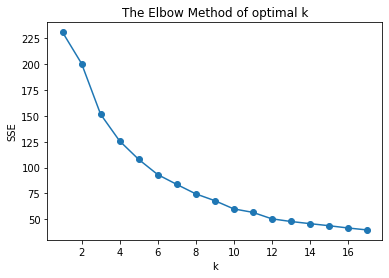

According to the graph above, we can see that 8 is the optimal value. 


In [14]:
#part2 Classification:
#Feature Engineering
#Preparation

#Choose the best K for Kmean

from sklearn import metrics 

MC0 = MC.loc[:, "mcg":"nuc"]
# creat a empty array
Knum = []

# put the data, which is the sum of squared distances of samples to their closest cluster centre, into the array.
K = range(1,18)
for k in K:
    km = KMeans(n_clusters=k, random_state=0)
    km.fit(MC0)
    Knum.append(km.inertia_)
    
# Plot the elbow plot
plt.plot(K, Knum, 'o-')
plt.title('The Elbow Method of optimal k')
plt.xlabel('k')
plt.ylabel('SSE')
plt.show()

print("According to the graph above, we can see that 8 is the optimal value. ")

In [15]:
#part2 Classification:
#Feature Engineering

#Feature generation

#Just use interaction term pairs
def featuregenerationInter():
    #We can manipulate the varibles outside the function
    global Xtrain, Xtest, Ytrain, Ytest
    
    #Remove the "class" firt
    MC1= MC.loc[:, "mcg":"nuc"]
    #Interaction term pairs as mention on the quesion and tried different combination
    MC1['new_feature1'] = MC1['mcg'] * MC1['alm']
    MC1['new_feature2'] = MC1['gvh'] / MC1['mit']
    MC1['new_feature3'] = MC1['vac'] * MC1['nuc']
#     MC1['new_feature4'] = MC1['pox'] / MC1['vac']
#     MC1['new_feature5'] = MC1['mcg'] / MC1['mit']
#     MC1['new_feature6'] = MC1['gvh'] * MC1['mit']
#     MC1['new_feature7'] = MC1['erl'] / MC1['vac']
    
    #Change the 'class' as string
    MC1['Class'] = yeast['Class']
    
    #Set and split x and y
    #x is all features
    x = MC1.loc[:, "mcg":"new_feature3"]
    #y is CYT or NON CYT  
    y = MC1.loc[:, 'Class']

    #Split train set and test set
    #Use 2/3(0.66667) of data for training
    #Use 1/3(0.33333)  of data for testing
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(x, y, test_size=0.33333, random_state = 0)

#Apply and print the Feature generation
print("------- after feature generation(just Interaction term pairs) -------") 
featuregenerationInter()
knnfunc(5)
knnfunc(10)
print(" ")     

#Just use clustering labels
def featuregenerationLa():
    #We can manipulate the varibles outside the function
    global Xtrain, Xtest, Ytrain, Ytest
    
    #Remove the "class" firt
    MC2 = MC.loc[:, "mcg":"nuc"]
    
    #Use the Kmeans to generate new features as mention on the quesion
    #I tried different k clusters. when the clusters = 2 we can get the best result 
    pred = KMeans(n_clusters=8, random_state=0).fit_predict(MC2)
    MC2['new_feature0'] = pred

    #Change the 'class' as string
    MC2['Class'] = yeast['Class']
    
    #Set and split x and y
    #x is all features
    x = MC2.loc[:, "mcg":"new_feature0"]
    #y is CYT or NON CYT  
    y = MC2.loc[:, 'Class']

    #Split train set and test set
    #Use 2/3(0.66667) of data for training
    #Use 1/3(0.33333)  of data for testing
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(x, y, test_size=0.33333, random_state = 0)

#Apply and print the Feature generation
print("------- after feature generation(just Clustering labels) -------") 
featuregenerationLa()
knnfunc(5)
knnfunc(10)   
print(" ") 

#Use both interaction term pairs and clustering labels
def featuregenerationall():
    #We can manipulate the varibles outside the function
    global Xtrain, Xtest, Ytrain, Ytest

    #Remove the "class" feature for Kmeans, and after Feature generation, we put back
    MC3 = MC.loc[:, "mcg":"nuc"]

    #Use the Kmeans to generate new features as mention on the quesion
    #I tried different k clusters. when the clusters = 2 we can get the best result 
    pred = KMeans(n_clusters=8, random_state=0).fit_predict(MC3)
    MC3['new_feature0'] = pred

    #Interaction term pairs as mention on the quesion and tried different combination
    MC3['new_feature1'] = MC3['mcg'] * MC3['alm']
    MC3['new_feature2'] = MC3['gvh'] / MC3['mit']
    MC3['new_feature3'] = MC3['vac'] * MC3['nuc']
#     MC3['new_feature4'] = MC3['pox'] / MC['vac']
#     MC3['new_feature5'] = MC3['mcg'] / MC['mit']
#     MC3['new_feature6'] = MC3['gvh'] * MC['mit']
#     MC3['new_feature7'] = MC3['erl'] / MC['vac']
    
    #Change the 'class' as string
    MC3['Class'] = yeast['Class']
    
    #Set and split x and y
    #x is all features
    x = MC3.loc[:, "mcg":"new_feature3"]
    #y is CYT or NON CYT  
    y = MC3.loc[:, 'Class']

    #Split train set and test set
    #Use 2/3(0.66667) of data for training
    #Use 1/3(0.33333)  of data for testing
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(x, y, test_size=0.33333, random_state = 0)

#Apply and print the Feature generation
print("------- after feature generation(interaction term pairs and clustering labels) -------") 
featuregenerationall()
knnfunc(5)
knnfunc(10)   
print(" ")     
    
#Selection
def featureselect():
    #We can manipulate the varibles outside the function
    global Xtrain, Xtest, Ytrain, Ytest
    
    #Renew the 'Class'
    MC4 = MC.loc[:, "mcg":"nuc"]
    MC4['Class'] = yeast['Class']
    
    #Set and split x and y
    #x is all features
    x = MC4.loc[:, "mcg":"nuc"]
    #y is CYT or NON CYT  
    y = MC4.loc[:, 'Class']
    
    #We tried different K to see the result.
    #After experiments, I selected 4 features with mutual information
    x = SelectKBest(mutual_info_classif, k=4).fit_transform(x, y)

    #Split train set and test set
    #Use 2/3(0.66667) of data for training
    #Use 1/3(0.33333)  of data for testing
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(x, y, test_size=0.33333, random_state = 0)

#Apply and print the Selection
print("------- after feature selection -------")
featureselect()
knnfunc(5)
knnfunc(10)

------- after feature generation(just Interaction term pairs) -------
KNN = 5 accuracy: 0.7212121212121212
KNN = 10 accuracy: 0.7111111111111111
 
------- after feature generation(just Clustering labels) -------
KNN = 5 accuracy: 0.6686868686868687
KNN = 10 accuracy: 0.7070707070707071
 
------- after feature generation(interaction term pairs and clustering labels) -------
KNN = 5 accuracy: 0.7111111111111111
KNN = 10 accuracy: 0.7131313131313132
 
------- after feature selection -------
KNN = 5 accuracy: 0.694949494949495
KNN = 10 accuracy: 0.6747474747474748


In [16]:
#part2 Classification:
#Feature Engineering

#Feature selection+generation with clustering labels 

def featuregNsL():
    #We can manipulate the varibles outside the function
    global Xtrain, Xtest, Ytrain, Ytest
    
    
    #Remove the "class" feature for Kmeans, and after Feature generation, we put back
    MC5  = MC.loc[:, "mcg":"nuc"]

    #Use the Kmeans to generate new features as mention on the quesion
    #I tried different k clusters. when the clusters = 2 we can get the best result 
    pred = KMeans(n_clusters=8, random_state=0).fit_predict(MC5)
    MC5['new_feature0'] = pred
    
    #Change the 'class' as string
    MC5['Class'] = yeast['Class']
    
    #Set and split x and y
    #x is all features
    x = MC5.loc[:, "mcg":"new_feature0"]
    #y is CYT or NON CYT  
    y = MC5.loc[:, 'Class']
    
    #We tried different K to see the result.
    #After experiments, I selected 4 features with mutual information
    x = SelectKBest(mutual_info_classif, k=4).fit_transform(x, y)

    #Split train set and test set
    #Use 2/3(0.66667) of data for training
    #Use 1/3(0.33333)  of data for testing
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(x, y, test_size=0.33333, random_state = 0)

#Apply and print the Feature generation
print("------- Feature selection+generation with clustering labels -------") 
featuregNsL()
knnfunc(5)
knnfunc(10)

------- Feature selection+generation with clustering labels -------
KNN = 5 accuracy: 0.701010101010101
KNN = 10 accuracy: 0.7333333333333333
